In [58]:
# Importing the library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # visualization library based on matplotlib
from IPython.display import display # Manage multiple output per cell
import datetime

# Manage UTF-8 issue
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

In [59]:
# DB Sqlite connection
import sqlite3
db = "./data/db/soccer_predict.sqlite"
conn = sqlite3.connect(db)
cur = conn.cursor()

In [60]:
# Get all prematch
df = pd.read_sql_query("SELECT * FROM pre_matchs ORDER BY INFO_Date ASC;", conn)
df = (df[df.columns.drop(['index'])])
df.shape

(15801, 102)

In [61]:
# Remove all game between June (include) and October (include)
df['INFO_Date'] = pd.to_datetime(df['INFO_Date'])
df['INFO_Date'].dt.month
df = df[(df['INFO_Date'].dt.month < 6) | (df['INFO_Date'].dt.month > 10)]
df.shape

(11276, 102)

In [63]:
# Remove league I don't want
#df = df[(df['INFO_Div'] != 'E1') & (df['INFO_Div'] != 'E2') & (df['INFO_Div'] != 'SC0')]
#df = df[(df['INFO_Div'] == 'D1')]
#df = df[(df['INFO_Div'] != 'E0')]
df.shape

(11276, 102)

In [64]:
# Removing column where bet for Home Victory is too high or too low
df = df.drop(df[df.INFO_BbAvH < 0].index)
df = df.drop(df[df.INFO_BbAvH > 10].index)
df.shape

(11153, 102)

In [65]:
df.INFO_BbAvH.mean()

2.493078992199406

In [66]:
# Create a INFO_WIN column containing the gain. If bet success it's equal to odd -1, else -1 (lose you bet)
df['INFO_WIN'] = df['INFO_BbAvH']-1
df.loc[df.INFO_FTR != 'H', 'INFO_WIN'] = -1

In [67]:
# Statistic for Home victory odd between 2 and 4
display(plt.show(), 100. * df.INFO_FTR.value_counts() / len(df.INFO_FTR))

None

H    45.359993
A    29.355330
D    25.284677
Name: INFO_FTR, dtype: float64

In [68]:
# How much did you win per match if bet on all
df.INFO_WIN.mean()

-0.03402223616964045

In [69]:
# Keep season 2016/2017 for further test and don't use it for traning
date_start_current_season = datetime.date(2016, 8, 1)
df_current_season = df[(df['INFO_Date'] > date_start_current_season)]
df = df[(df['INFO_Date'] < date_start_current_season)]

In [70]:
df_current_season.shape

(2190, 103)

In [71]:
# Prepare the dataset
# Get the X and y
X = pd.get_dummies(df[df.columns.drop(['INFO_AwayTeam', 'INFO_BbAvA', 'INFO_BbAvD', 'INFO_BbAvH', 'INFO_Date', 'INFO_FTAG', 'INFO_FTHG', 'INFO_FTR', 'INFO_HTR', 'INFO_HomeTeam', 'INFO_PSA', 'INFO_PSD', 'INFO_PSH', 'INFO_WIN'])])
y = pd.get_dummies(df)['INFO_FTR_H'].astype('bool_')
X_current_season = pd.get_dummies(df_current_season[df_current_season.columns.drop(['INFO_AwayTeam', 'INFO_BbAvA', 'INFO_BbAvD', 'INFO_BbAvH', 'INFO_Date', 'INFO_FTAG', 'INFO_FTHG', 'INFO_FTR', 'INFO_HTR', 'INFO_HomeTeam', 'INFO_PSA', 'INFO_PSD', 'INFO_PSH', 'INFO_WIN'])])
y_current_season = pd.get_dummies(df_current_season)['INFO_FTR_H'].astype('bool_')

In [72]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [73]:
y_train.value_counts()

False    3482
True     2792
Name: INFO_FTR_H, dtype: int64

In [74]:
y_test.value_counts()

False    1490
True     1199
Name: INFO_FTR_H, dtype: int64

In [17]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
X_current_season = sc_X.fit_transform(X_current_season)

In [18]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
classifier = GaussianNB()
f1_score = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring='f1')
recall = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring='recall')
precision = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=4, n_jobs=-1, scoring='precision')
display('f1:',f1_score.mean(), f1_score.std())
display('recall:',recall.mean(), recall.std())
display('precision:',precision.mean(), precision.std())

'f1:'

0.39645004325939126

0.011028116849466946

'recall:'

0.38175449033581005

0.013164475049204122

'precision:'

0.41260663761937716

0.01324713828018388

In [19]:
from sklearn.model_selection import GridSearchCV
parameters = [{}]
clf = GridSearchCV(estimator=classifier,
                   param_grid=parameters,
                   scoring='f1',
                   cv=4,
                   n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_score_

0.39645061117034963

In [20]:
# Fit data with the best hyper-parameters
#clf = GaussianProcessClassifier(random_state=0)
#clf.fit(X_train, y_train)

In [21]:
# Predicting the Test set result
y_pred = clf.predict(X_test)

In [22]:
# Calculate target classification probability (got % instead of 1 or 0)
y_probs = clf.predict_proba(X_test)

In [23]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.44338118022328549, 0.3855755894590846, 0.41246290801186941, None)

In [24]:
# Making the confusion Matrix
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,709,349,1058
True,443,278,721
All,1152,627,1779


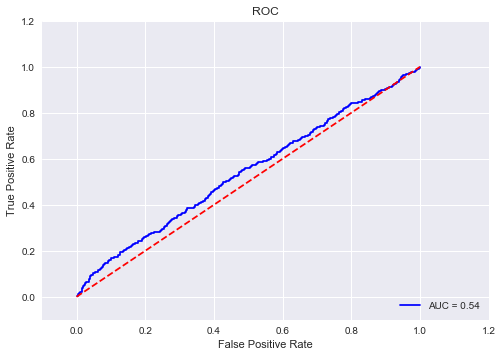

In [25]:
# Plot of a ROC curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.ravel(), y_probs[:, 1].ravel())
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ALL DATASET TEST

In [26]:
# Apply on all the dataset
X_pred = clf.predict(X)
df['pred'] = X_pred
df_bet_home = df.drop(df[df.pred == 0].index)

In [27]:
# How many Home victory bet I did on Home Victory on all dataset
df_bet_home.shape

(2078, 104)

In [28]:
# What will be the real result of what I bet Home victory on all dataset
display(plt.show(), 100. * df_bet_home.INFO_FTR.value_counts() / len(df_bet_home.INFO_FTR))

None

H    44.562079
A    29.788258
D    25.649663
Name: INFO_FTR, dtype: float64

In [29]:
# Score for all dataset
precision_recall_fscore_support(y, X_pred, average='binary') 

(0.44562078922040421, 0.4006923409779316, 0.42196400091136937, None)

In [30]:
# Making the confusion Matrix
df_confusion = pd.crosstab(y, X_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,2466,1152,3618
True,1385,926,2311
All,3851,2078,5929


In [31]:
df_bet_home.INFO_WIN.mean()

-0.01832050048123193

# SEASON 2016/2017 TEST

In [32]:
# Apply on current season that is not use for train and test set
X_pred_current_season = clf.predict(X_current_season)
df_current_season['pred'] = X_pred_current_season
df_bet_home_current_season = df_current_season.drop(df_current_season[df_current_season.pred == 0].index)

In [33]:
# How many Home victory bet I did on Home Victory
df_bet_home_current_season.shape

(491, 104)

In [34]:
# What will be the real result of what I bet Home victory
display(plt.show(), 100. * df_bet_home_current_season.INFO_FTR.value_counts() / len(df_bet_home_current_season.INFO_FTR))

None

H    48.268839
D    27.494908
A    24.236253
Name: INFO_FTR, dtype: float64

In [35]:
# Score for this current season
precision_recall_fscore_support(y_current_season, X_pred_current_season, average='binary') 

(0.48268839103869654, 0.41652021089630931, 0.44716981132075473, None)

In [36]:
# Making the confusion Matrix
df_confusion = pd.crosstab(y_current_season, X_pred_current_season, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,511,254,765
True,332,237,569
All,843,491,1334


In [37]:
df_bet_home_current_season.INFO_WIN.mean()

0.06431771894093682

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = pd.get_dummies(df[df.columns.drop(['INFO_AwayTeam', 'INFO_BbAvA', 'INFO_BbAvD', 'INFO_BbAvH', 'INFO_Date', 'INFO_FTAG', 'INFO_FTHG', 'INFO_FTR', 'INFO_HTR', 'INFO_HomeTeam', 'INFO_PSA', 'INFO_PSD', 'INFO_PSH', 'INFO_WIN'])])
y = pd.get_dummies(df)['INFO_FTR_H'].astype('bool_')

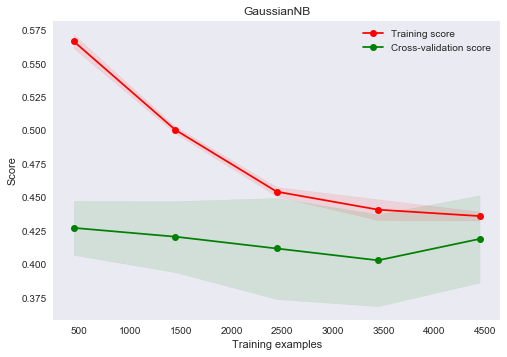

In [39]:
plot_learning_curve(GaussianNB(), 'GaussianNB', X, y, cv=4, n_jobs=4).show()
plt.show()

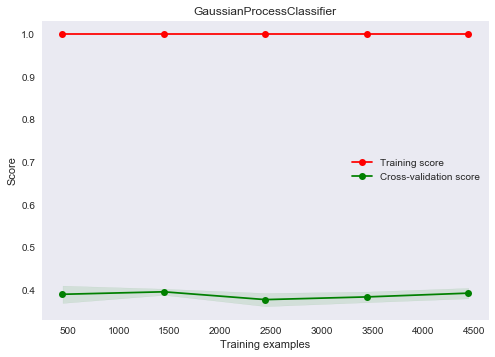

In [40]:
plot_learning_curve(GaussianProcessClassifier(), 'GaussianProcessClassifier', X, y, cv=4, n_jobs=4).show()
plt.show()

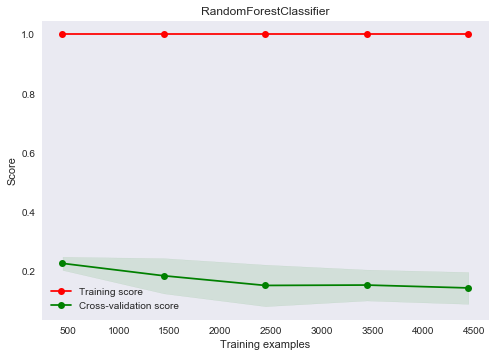

In [41]:
plot_learning_curve(RandomForestClassifier(random_state=0, n_estimators=100), 'RandomForestClassifier', X, y, cv=4, n_jobs=4).show()
plt.show()

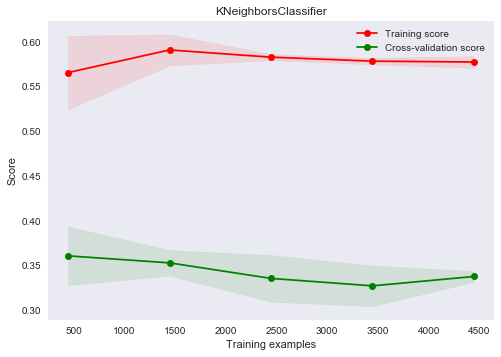

In [42]:
plot_learning_curve(KNeighborsClassifier(), 'KNeighborsClassifier', X, y, cv=4, n_jobs=4).show()
plt.show()

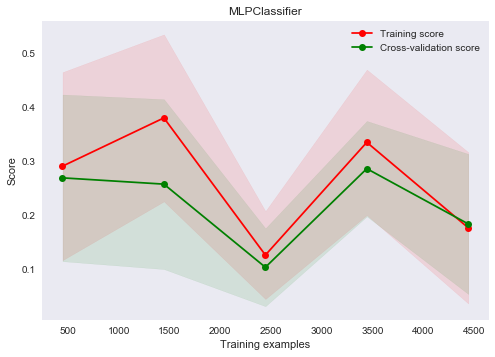

In [43]:
plot_learning_curve(MLPClassifier(), 'MLPClassifier', X, y, cv=4, n_jobs=4).show()
plt.show()

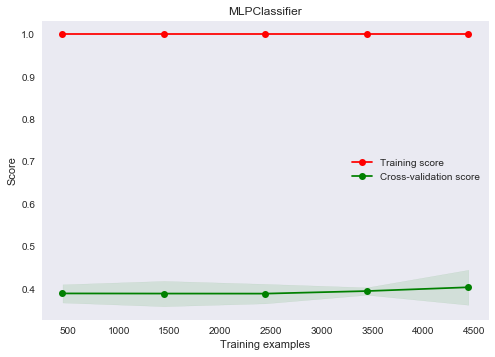

In [44]:
plot_learning_curve(DecisionTreeClassifier(), 'DecisionTreeClassifier', X, y, cv=4, n_jobs=4).show()
plt.show()

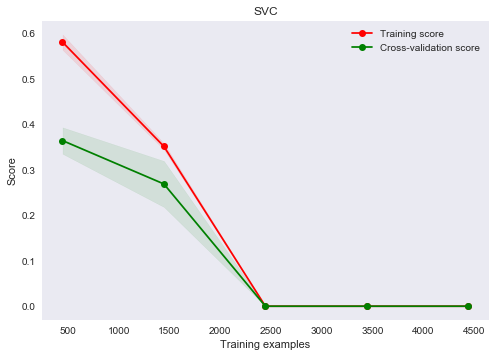

In [45]:
plot_learning_curve(SVC(kernel='linear'), 'SVC', X, y, cv=4, n_jobs=4).show()
plt.show()

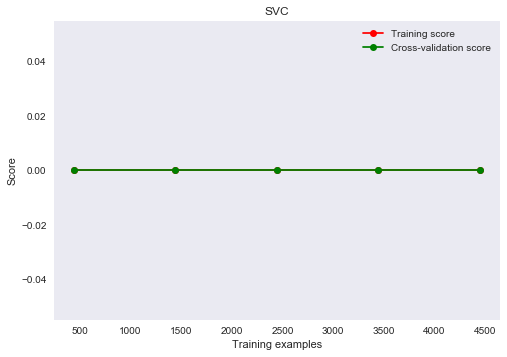

In [46]:
plot_learning_curve(SVC(kernel='sigmoid'), 'SVC', X, y, cv=4, n_jobs=4).show()
plt.show()

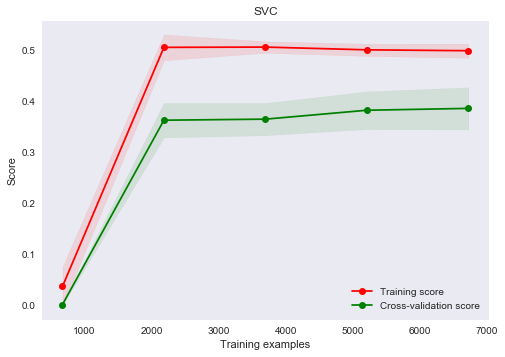

In [81]:
plot_learning_curve(SVC(kernel='rbf', C=0.3), 'SVC', X, y, cv=4, n_jobs=4).show()
plt.show()